In [2]:
%load_ext autoreload
%autoreload 2
question_pt = 'data/v2_OpenEnded_mscoco_val2014_questions.json' 
feature_h5_folder = 'data/rcnn_feature' # path to trainval_feature.h5
image_dir = 'data/images/mscoco/images/' # path to mscoco/val2014, containing all mscoco val images
ann_file = 'data/images/mscoco/annotations/instances_val2014.json' # path to mscoco/annotations/instances_val2014.json

In [3]:
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os,sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(sys.argv[1])))) # to import shared utils
import torch
import numpy as np
# import pickle
import json
import h5py
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import _pickle as cPickle
import re

def invert_dict(d):
    return {v: k for k, v in d.items()}

def expand_batch(*args):
    return (t.unsqueeze(0) for t in args)

def todevice(tensor, device):
    if isinstance(tensor, list) or isinstance(tensor, tuple):
        assert isinstance(tensor[0], torch.Tensor)
        return [todevice(t, device) for t in tensor]
    elif isinstance(tensor, torch.Tensor):
        return tensor.to(device)

/home/gerald/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import pickle
from dataset import Dictionary, VQAFeatureDataset
##prepare data
name = 'val'  # train or val
answer_path = os.path.join('data', 'cp-cache', '%s_target.pkl' % name)
name = "train" if name == "train" else "test"
question_path = os.path.join('data', 'vqacp_v2_%s_questions.json' % name)

with open(question_path) as f:
    questions = json.load(f)
with open(answer_path, 'rb') as f:
    answers = cPickle.load(f)
    
questions.sort(key=lambda x: x['question_id'])
answers.sort(key=lambda x: x['question_id'])
    
dictionary = Dictionary.load_from_file('data/dictionary.pkl')

dset = VQAFeatureDataset('val', dictionary, dataset='cpv2',
                                #   cache_image_features=args.cache_features)
                                cache_image_features=False)

loading dictionary from data/dictionary.pkl


load-dataset: 49976it [00:00, 499548.48it/s]

219928


load-dataset: 219928it [00:00, 483117.83it/s]
tensorize: 100%|████████████████████████████████████████| 219928/219928 [00:02<00:00, 109509.69it/s]


In [5]:
def plot_rect(image, boxes):
    img = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(img)
    for k in range(15):
        box = boxes[k,:]
        drawrect(draw, box, outline='green', width=3)
    img = np.asarray(img)
    return img
def drawrect(drawcontext, xy, outline=None, width=0):
    x1, y1, x2, y2 = xy
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

In [6]:
def _load_image(image_id, dataset):
    """ Load an image """
    if img_id in dset.image_id2ix['train'].keys():
        split = 'train'
        img_idx = dset.image_id2ix['train'][img_id]
    else:
        split = 'val'
        img_idx = dset.image_id2ix['val'][img_id]

    name = (12 - len(str(image_id))) * '0' + str(image_id)
    img = io.imread(os.path.join(image_dir, split+'2014', 'COCO_'+split+'2014_' + name + '.jpg'))
    bboxes = torch.from_numpy(np.array(dataset.spatial[split][img_idx][:, :4]))
    return img, bboxes

What is the object in the water?


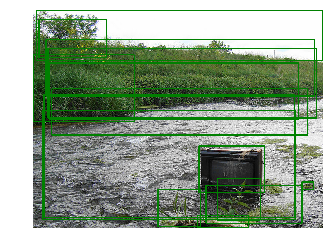

In [34]:
import utils
from torch.autograd import Variable
##choose an image question pair
index = 193
question = questions[index]
img_id = question['image_id']

img, bbox = _load_image(img_id, dset)
    
print(question['question'])
plot_img = plot_rect(copy.copy(img), bbox)
plt.axis('off')
plt.imshow(plot_img)
    
v, q, a, b, qid, hint_score = dset.__getitem__(index)
utils.assert_eq(question['question_id'], qid)
v = Variable(v, requires_grad=False).cuda()
q = Variable(q, requires_grad=False).cuda()
hint_score = Variable(hint_score, requires_grad=False).cuda()

In [35]:
import base_model as base_model
from vqa_debias_loss_functions import *
ckpt_path = 'logs/updn/model.pth'
constructor = 'build_%s' % 'baseline0_newatt'
model = getattr(base_model, constructor)(dset, 1024).cuda()
model.w_emb.init_embedding('data/glove6b_init_300d.npy')
model.debias_loss_fn = Plain()
model.eval()
ckpt = torch.load(ckpt_path)

states_ = ckpt
model.load_state_dict(states_)

pred, _,atts = model(v.unsqueeze(0), q.unsqueeze(0), None, None, None)

In [36]:
prediction = torch.argmax(a).data.cpu()
dset.label2ans[prediction]

'tv'

In [37]:
from torch.nn import functional as F
pred = F.softmax(pred.squeeze(0), dim=0).cpu()
values, indices = pred.topk(5,dim=0, largest=True, sorted=True)
for i in indices:
    print(dset.label2ans[i])

boat
rocks
trash
trash can
bench


In [38]:
def plot_attention(img, boxes, att):
    white = np.asarray([255, 255, 255])
    pixel_peak = np.zeros((img.shape[0], img.shape[1]))
    for k in range(36):
        for i in range(int(boxes[k][1]), int(boxes[k][3])):
            for j in range(int(boxes[k][0]), int(boxes[k][2])):
                pixel_peak[i,j] = max(pixel_peak[i,j], att[k])
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            img[i,j] = white * (1-pixel_peak[i,j]) + img[i,j] * pixel_peak[i,j]
    if torch.max(att) > 0.5:
        red_box = boxes[torch.argmax(att),:]
        img = Image.fromarray(np.uint8(img))
        draw = ImageDraw.Draw(img)
        drawrect(draw, red_box, outline='red', width=4)
    img = np.asarray(img)
    return img

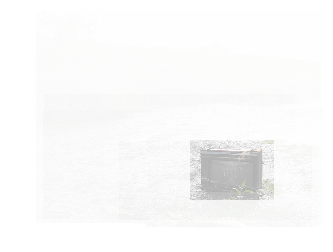

In [39]:
if atts.max() < 0.5:
    scale = 0.55 / atts.max()
else:
    scale = 1.
plot_img = plot_attention(copy.copy(img), bbox, atts.squeeze(0))
plt.axis('off')
plt.imshow(plot_img)

In [40]:
from PIL import Image
name = 'figures/updn' + str(index) + '_mask.jpg'
im = Image.fromarray(plot_img)
im.save(name)

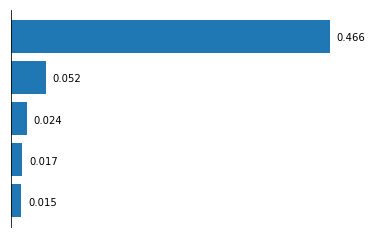

In [41]:
x = range(len(values))
fig, ax = plt.subplots()
y, _ = values.sort(0, descending=False)
y=y.data.numpy()
plt.barh(x, y)
ax.spines['right'].set_color('none')  # right边框属性设置为none 不显示
ax.spines['top'].set_color('none')    # top边框属性设置为none 不显示
ax.spines['bottom'].set_color('none')
plt.xticks([])
plt.yticks([])
for x, y in enumerate(y):
    plt.text(y +0.01, x - 0.1, '%.3f' % y)  
name = 'figures/' + str(index) +'_prob.jpg'
plt.savefig(name)
plt.show()